In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
# import squidpy as sq

# import muon as mu
import mudata as mu

In [2]:
import liana as li

In [3]:
## load slide
slide = "B1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"data/VicariEtAl/sma/{exp}/{exp}_{slide}/output_data"

NOTE: This requires coordinates to be in the same system (e.g. pixels on the image)

In [4]:
mdata = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
rna = mdata.mod["rna"]
msi = mdata.mod["msi"]

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
rna.var_names_make_unique()
msi.var_names_make_unique()

In [6]:
mdata

MuData object with n_obs × n_vars = 6125 × 33823
  2 modalities
    rna:	3120 x 32285
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region'
      var:	'gene_ids', 'feature_types', 'genome'
      uns:	'spatial'
      obsm:	'spatial'
    msi:	3005 x 1538
      obs:	'leiden', 'array_row', 'array_col', 'x', 'y'
      var:	'mean', 'std'
      uns:	'leiden_colors', 'spatial'
      obsm:	'X_pca', 'spatial'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

## Process RNA

In [7]:
sc.pp.filter_cells(rna, min_genes=200)
sc.pp.filter_cells(rna, min_counts=100)
sc.pp.filter_genes(rna, min_cells=3)

In [8]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

In [9]:

sc.pp.highly_variable_genes(rna, flavor='cell_ranger', n_top_genes=200)

In [10]:
rna = rna[:, rna.var['highly_variable']]

In [11]:
rna

View of AnnData object with n_obs × n_vars = 3050 × 200
    obs: 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

## Process metabolites

In [12]:
# change type to float
msi.var['mz'] = msi.var.index.astype(float)
# round to 2 decimals
msi.var['mz'] = [round(x, 2) for x in msi.var['mz']]

In [13]:
msi.var['max_intensity'] = msi.X.sum(axis=0)

In [14]:
molecule_weights = {
    'GABA': 371.18,
    'GABA-H2O': 353.16,
    'Taurine': 393.13,
    'Serotonin': 444.21,
    'Histidine': 423.18,
    '3-MT': 435.21,
    'Dopamine (single)': 421.19,
    'Dopamine (double)': 674.28,
    'DOPAC': 689.24,
    'NE (Norepinephrine)': 690.28,
    'Tocopherol': 698.49
}

In [15]:
# show m/z with matching molecule weight
msk = msi.var['mz'].isin(molecule_weights.values())

In [16]:
msi = msi[:, msk]

In [17]:
msi.var['name'] = msi.var['mz'].map({v: k for k, v in molecule_weights.items()})
msi.var['name'] = msi.var['name'].astype('category')
msi.var.index = msi.var['name']

/tmp/ipykernel_398541/1051884205.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


In [18]:
from matplotlib import pyplot as plt

In [19]:
msi.X.sum(axis=1)

array([-0.7011012 , -0.95237535, -0.93106604, ..., -2.3950171 ,
       -0.74203223, -2.216792  ], dtype=float32)

(array([971., 389., 399., 284., 215., 187., 129., 126.,  73.,  59.,  58.,
         36.,  18.,  20.,  13.,   9.,   8.,   5.,   2.,   2.,   0.,   0.,
          1.,   0.,   1.]),
 array([-2.3950171e+00, -1.2054020e+00, -1.5786991e-02,  1.1738281e+00,
         2.3634431e+00,  3.5530581e+00,  4.7426734e+00,  5.9322882e+00,
         7.1219034e+00,  8.3115187e+00,  9.5011339e+00,  1.0690749e+01,
         1.1880363e+01,  1.3069979e+01,  1.4259594e+01,  1.5449209e+01,
         1.6638824e+01,  1.7828440e+01,  1.9018055e+01,  2.0207670e+01,
         2.1397284e+01,  2.2586899e+01,  2.3776514e+01,  2.4966129e+01,
         2.6155745e+01,  2.7345360e+01], dtype=float32),
 <BarContainer object of 25 artists>)

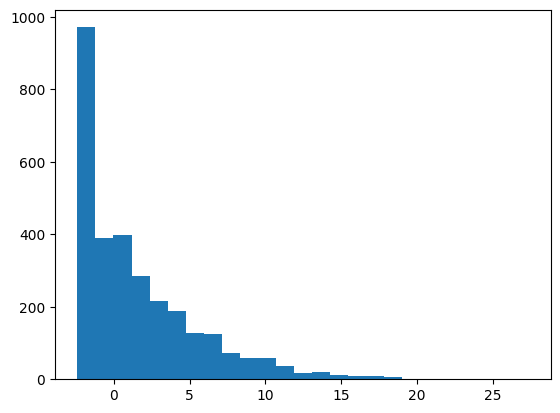

In [20]:
x = msi.X.sum(axis=1)

# histogram of total ion count
plt.hist(np.array(x), bins=25)

Test

In [21]:
# get reference coordinates
reference = mdata.mod["rna"].obsm["spatial"]


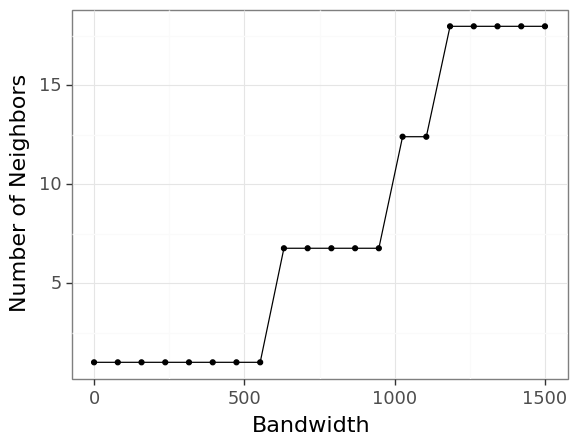

<ggplot: (8727918569911)>

In [22]:
plot, _ = li.ut.query_bandwidth(coordinates=rna.obsm['spatial'], start=0, end=1500, interval_n=20, reference=reference)
plot

In [23]:

# distances of metabolties to RNA
li.ut.spatial_neighbors(msi, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [24]:
# get reference coordinates
reference = mdata.mod["msi"].obsm["spatial"]

# distances of metabolties to RNA
li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [25]:
import squidpy as sq

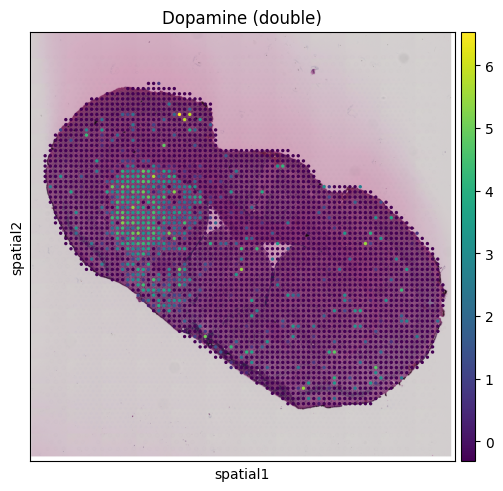

In [26]:
sq.pl.spatial_scatter(msi, color="Dopamine (double)")

In [27]:
# spatial weight all as 1
# w = np.zeros((msi.obsm['spatial_connectivities'].T.shape))

In [28]:
w = msi.obsm['spatial_connectivities'].T

In [29]:
# Apply Spatial Smoothing with RNA as reference
msi_smooth = w @ msi.X
msi_smooth = sc.AnnData(X=msi_smooth, obs=rna.obs, obsm=rna.obsm, uns=rna.uns, var=msi.var)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


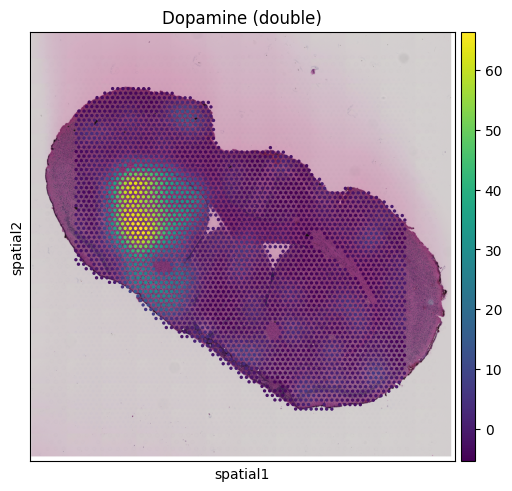

In [31]:
sq.pl.spatial_scatter(msi_smooth, color="Dopamine (double)")

Mitsy

In [32]:
mdata.update_obs()

In [33]:
misty = li.mt.MistyData({"intra": msi, "inter":rna}, enforce_obs=False, obs=mdata.obs)


view intra is not a csr_matrix. Converting to csr_matrix


In [34]:
misty(model="linear", verbose=True, bypass_intra=True)

Now learning: Tocopherol: 100%|██████████| 8/8 [00:11<00:00,  1.47s/it]       


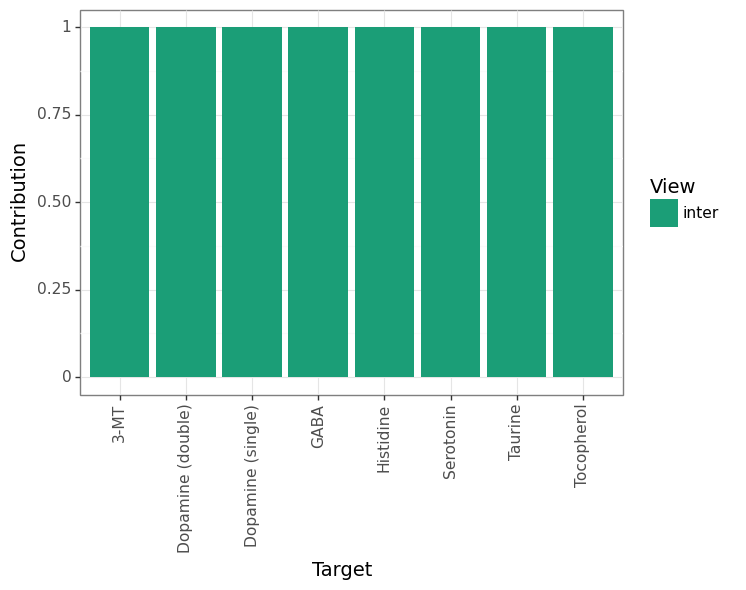

<ggplot: (8727925200803)>

In [35]:
li.pl.contributions(misty, return_fig=True)

In [36]:
misty.uns['target_metrics']

,target,intra_R2,multi_R2,gain_R2,inter
0,GABA,0,0.000000,0.000000,1.0
1,Taurine,0,0.000000,0.000000,1.0
2,Dopamine (single),0,0.037056,0.037056,1.0
3,Histidine,0,0.000000,0.000000,1.0
4,3-MT,0,0.623261,0.623261,1.0
5,Serotonin,0,0.000000,0.000000,1.0
6,Dopamine (double),0,0.346425,0.346425,1.0
7,Tocopherol,0,0.000000,0.000000,1.0


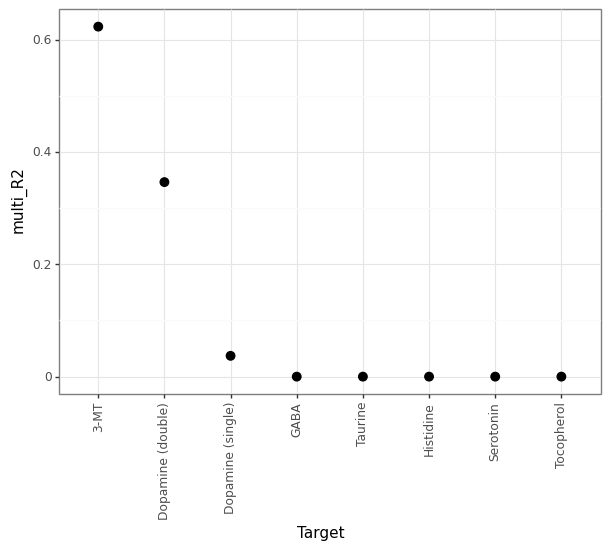

<ggplot: (8727916104452)>

In [37]:
li.pl.target_metrics(misty, stat='multi_R2', return_fig=True)


In [43]:
misty.uns['interactions'].sort_values("importances").tail(20)

,target,predictor,view,importances
878,3-MT,Gsn,inter,3.898323
574,Dopamine (single),Syndig1l,inter,3.983549
1330,Dopamine (double),Pde10a,inter,4.050498
945,3-MT,Prr5l,inter,4.123923
837,3-MT,Crym,inter,4.233031
1376,Dopamine (double),Tac1,inter,4.530293
930,3-MT,Pde10a,inter,4.669334
940,3-MT,Pltp,inter,4.741111
950,3-MT,Rgs9,inter,4.936085
925,3-MT,Olig2,inter,4.958428


In [41]:
# Apply Spatial Smoothing with RNA as reference
w2 = li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", inplace=False, set_diag=False, standardize=False)
rna.layers['smooth'] = w2 @ rna.X

In [57]:
rna_smooth = rna[:, 'Pdyn'].layers['smooth'].copy()

In [71]:
sc.AnnData(msi_smooth[:,'Dopamine (double)'].X * rna_smooth.A.flatten())

AnnData object with n_obs × n_vars = 3050 × 3050

In [85]:
import muon as mu

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [91]:
mdata = mu.MuData({'rna':rna, 'msi':msi_smooth}, obs=rna.obs, uns=rna.uns)

In [93]:
mdata

MuData object with n_obs × n_vars = 3050 × 208
  obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
  2 modalities
    rna:	3050 x 200
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'spatial', 'log1p', 'hvg'
      obsm:	'spatial', 'spatial_connectivities'
      layers:	'smooth'
    msi:	3050 x 8
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
      var:	'mean', 'std', 'mz', 'max_intensity', 'name'
      uns:	'spatial', 'log1p', 'hvg'
      obsm:	'spatial', 'spatial_connectivities'

In [127]:
from scipy.sparse import csr_matrix
w3 = np.zeros((mdata.shape[0], mdata.shape[0]))
w3 = csr_matrix(w3)
w3.setdiag(1)
mdata.obsp['spatial_connectivities'] = w3

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [128]:
mdata

MuData object with n_obs × n_vars = 3050 × 208
  obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
  obsp:	'spatial_connectivities'
  3 modalities
    rna:	3050 x 200
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'spatial', 'log1p', 'hvg', 'global_res'
      obsm:	'spatial', 'spatial_connectivities'
      layers:	'smooth'
    msi:	3050 x 8
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
      var:	'mean', 'std', 'mz', 'max_intensity', 'name'
      uns:	'spatial', 'log1p', 'hvg'
      obsm:	'spatial', 'spatial_connectivities'
    local_scores:	3050 x 1
      obs:	'rna:in_tissue', 'rna:array_row', 'rna:array_col', 'rna:x', 'rna:y', 'rna:lesion', 'rna:region', 'rna:n_genes', 'rna:n_counts', 'msi:in_tissue', 'msi:array_row', 'msi:array_col', 'msi:x', 'msi:y', 'msi:lesion', 'msi:region', 'msi:n_genes', 'msi:n_counts', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
      uns:	'spatial', 'log1p', 'hvg', 'global_res'
      obsm:	'rna', 'msi'
      obsp:	'spatial_connectivities'

In [135]:
li.mt.bivar(mdata, function_name='product', x_mod='rna', y_mod='msi', x_layer='smooth', x_use_raw=False, y_use_raw=False, verbose=True, interactions = [('Pdyn', 'Dopamine (double)')])

Using provided `interactions`.
Using the `smooth` layer!
Using `.X`!
Converting to sparse csr matrix!
Using `.X`!


In [136]:
mdata.mod['local_scores'].obsm = rna.obsm

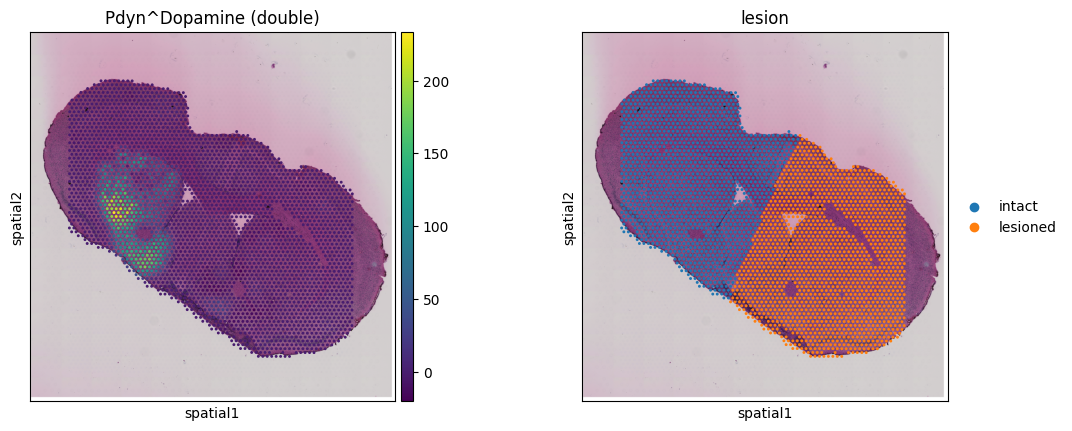

In [139]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], color=['Pdyn^Dopamine (double)', 'lesion'])

In [138]:
mdata.mod['local_scores'].obs

,rna:in_tissue,rna:array_row,rna:array_col,rna:x,rna:y,rna:lesion,rna:region,rna:n_genes,rna:n_counts,msi:in_tissue,...,msi:n_counts,in_tissue,array_row,array_col,x,y,lesion,region,n_genes,n_counts
AAACAAGTATCTCCCA-1,1,50,102,34740,30651,lesioned,striatum,1562,3491.0,1,...,3491.0,1,50,102,34740,30651,lesioned,striatum,1562,3491.0
AAACAGCTTTCAGAAG-1,1,43,9,7784,27046,intact,not_striatum,626,1454.0,1,...,1454.0,1,43,9,7784,27046,intact,not_striatum,626,1454.0
AAACATTTCCCGGATT-1,1,61,97,33275,36197,lesioned,striatum,2275,5784.0,1,...,5784.0,1,61,97,33275,36197,lesioned,striatum,2275,5784.0
AAACCCGAACGAAATC-1,1,45,115,38516,28139,lesioned,not_striatum,1193,2048.0,1,...,2048.0,1,45,115,38516,28139,lesioned,not_striatum,1193,2048.0
AAACCGGAAATGTTAA-1,1,54,124,41113,32686,lesioned,not_striatum,1127,1846.0,1,...,1846.0,1,54,124,41113,32686,lesioned,not_striatum,1127,1846.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,23757,17504,intact,not_striatum,2813,6917.0,1,...,6917.0,1,24,64,23757,17504,intact,not_striatum,2813,6917.0
TTGTTCTAGATACGCT-1,1,21,3,6074,15942,intact,not_striatum,2473,5693.0,1,...,5693.0,1,21,3,6074,15942,intact,not_striatum,2473,5693.0
TTGTTGTGTGTCAAGA-1,1,31,77,27517,21045,lesioned,not_striatum,2835,7132.0,1,...,7132.0,1,31,77,27517,21045,lesioned,not_striatum,2835,7132.0
TTGTTTCCATACAACT-1,1,45,27,13000,28069,intact,striatum,2751,8027.0,1,...,8027.0,1,45,27,13000,28069,intact,striatum,2751,8027.0


In [ ]:
li.mt.bivar(mdata, )

In [101]:
mdata.mod['local_scores'].var

""
interaction
Pdyn^Dopamine (double)
